In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary

# Check for GPU availability: if a CUDA-compatible GPU is available, use it for computations;
# otherwise, fall back to using the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define a ResidualBlock used to build the ResNet-like architecture.

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Build a series of residual layers:
        # Layer 1: Processes the input without downsampling, increasing channels from 32 to 64.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out
# Define the CustomResNet architecture ensuring the total parameters ≤ 5M.
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        # The first convolutional layer processes the input image (e.g., 32x32 RGB) and increases the channel count to 32.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        # Batch normalization helps stabilize and speed up training.
         # ReLU adds non-linearity.
        self.relu = nn.ReLU(inplace=True)
        # Build a series of residual layers:
        # Layer 1: Processes the input without downsampling, increasing channels from 32 to 64.
        self.layer1 = self._make_layer(32, 64, 2, stride=1)
        # Layer 2: Downsamples the spatial dimensions (stride=2) and increases channels from 64 to 128.
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        # Layer 3: Further downsampling and increasing channels from 128 to 256.
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        # Adaptive average pooling reduces each feature map to a single value.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Final fully connected layer outputs scores for each class.
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
          # Create a sequence of residual blocks. The first block can change dimensions if needed.
        layers = [ResidualBlock(in_channels, out_channels, stride)]
         # Remaining blocks simply refine the features.
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # Pool to compress the spatial dimensions.
        x = self.avg_pool(x)
        # Flatten the tensor for the fully connected layer.
        x = torch.flatten(x, 1)
          # Generate final class scores.
        x = self.fc(x)
        return x

# Initialize model
model = CustomResNet().to(device)

# Check model parameter count
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Kaggle dataset path
DATASET_PATH = "/kaggle/input/resnet/cifar-10-python"

# Load CIFAR-10 dataset from Kaggle's input directory
trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("Dataset loaded successfully from Kaggle input directory.")

Dataset loaded successfully from Kaggle input directory.


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print("Training Complete!")

Epoch 1, Loss: 1.3602
Epoch 2, Loss: 0.9167
Epoch 3, Loss: 0.7350
Epoch 4, Loss: 0.6105
Epoch 5, Loss: 0.5341
Epoch 6, Loss: 0.4737
Epoch 7, Loss: 0.4222
Epoch 8, Loss: 0.3858
Epoch 9, Loss: 0.3562
Epoch 10, Loss: 0.3302
Epoch 11, Loss: 0.3016
Epoch 12, Loss: 0.2836
Epoch 13, Loss: 0.2642
Epoch 14, Loss: 0.2433
Epoch 15, Loss: 0.2280
Epoch 16, Loss: 0.2158
Epoch 17, Loss: 0.1966
Epoch 18, Loss: 0.1894
Epoch 19, Loss: 0.1744
Epoch 20, Loss: 0.1637
Epoch 21, Loss: 0.1517
Epoch 22, Loss: 0.1430
Epoch 23, Loss: 0.1344
Epoch 24, Loss: 0.1242
Epoch 25, Loss: 0.1196
Epoch 26, Loss: 0.1125
Epoch 27, Loss: 0.1079
Epoch 28, Loss: 0.1026
Epoch 29, Loss: 0.0912
Epoch 30, Loss: 0.0921
Epoch 31, Loss: 0.0826
Epoch 32, Loss: 0.0814
Epoch 33, Loss: 0.0783
Epoch 34, Loss: 0.0750
Epoch 35, Loss: 0.0743
Epoch 36, Loss: 0.0662
Epoch 37, Loss: 0.0699
Epoch 38, Loss: 0.0617
Epoch 39, Loss: 0.0576
Epoch 40, Loss: 0.0564
Epoch 41, Loss: 0.0592
Epoch 42, Loss: 0.0579
Epoch 43, Loss: 0.0478
Epoch 44, Loss: 0.05

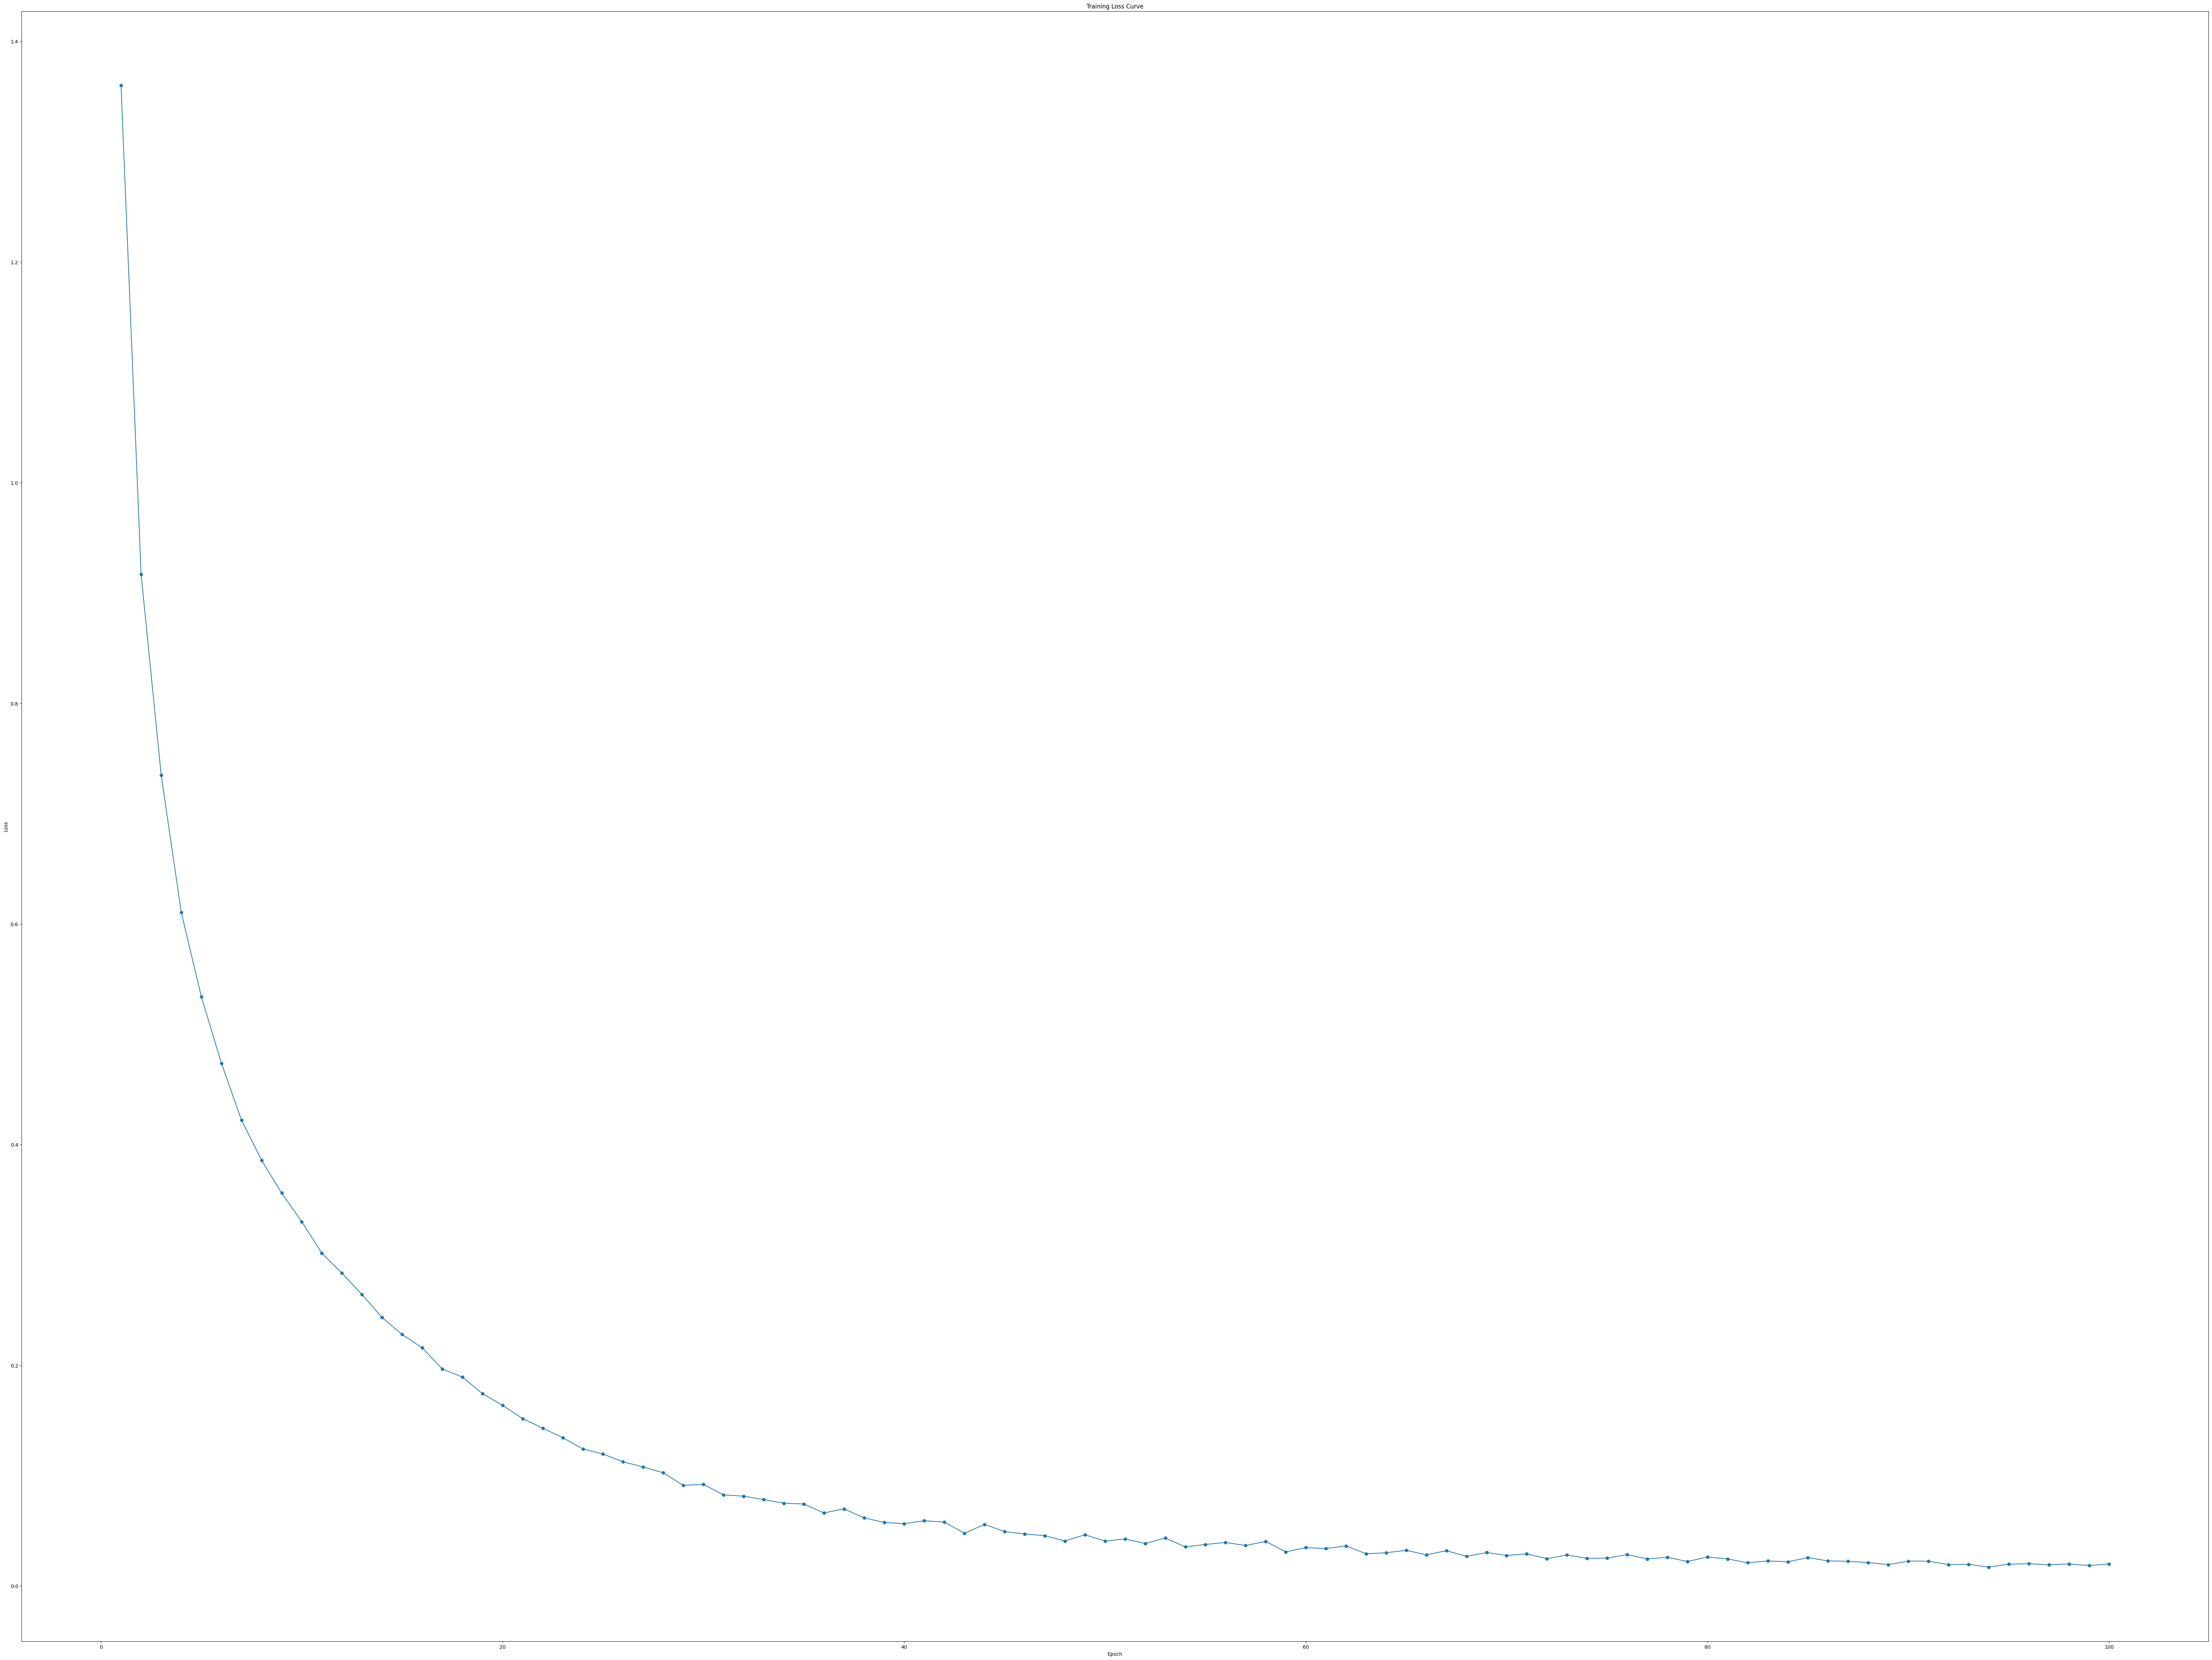

In [6]:
# Plot the training loss
plt.figure(figsize=(80,60))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [7]:
# Evaluate model performance
correct = 0
total = 0
model.eval() # Set the model to evaluation mode (disables dropout, etc.)
# Disable gradient calculations for efficiency during evaluation.
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
         # Update total sample count and add the number of correct predictions.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.31%


In [8]:
import pickle
import pandas as pd
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the unlabeled test dataset
pkl_file_path = "/kaggle/input/resnet/cifar_test_nolabel.pkl"

with open(pkl_file_path, "rb") as f:
    test_data = pickle.load(f)

# Extract images and IDs
test_images = test_data[b'data']  # Image pixel values
image_ids = test_data[b'ids']  # Corresponding image IDs

# Reshape to (N, 32, 32, 3) since CIFAR-10 images are 32x32 RGB
test_images = test_images.reshape(-1, 32, 32, 3)

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Convert images to PyTorch tensors and apply transformations
test_images = torch.stack([transform(img) for img in test_images])
test_images = test_images.to(device)  # Move to GPU/CPU

# Run inference
model.eval()
predictions = []

with torch.no_grad():
    for img in test_images:
        img = img.unsqueeze(0)  # Add batch dimension
        output = model(img)
        _, predicted_label = torch.max(output, 1)
        predictions.append(predicted_label.item())

# Save predictions to a CSV file (ImageID, Label format)
submission_df = pd.DataFrame({"ImageID": image_ids, "Label": predictions})
submission_df.to_csv("/kaggle/working/cifar10_predictions2.csv", index=False)

print("Predictions saved to cifar10_predictions.csv")


Predictions saved to cifar10_predictions.csv


So far, we have built a custom ResNet-like model with residual blocks that meets the parameter constraints, loaded and preprocessed the CIFAR-10 dataset, and trained the model for 100 epochs. The training loop was implemented with Adam optimization and cross-entropy loss, leading to a test accuracy of about 91.31%. Additionally, we performed inference on an unlabeled test dataset and saved the predictions to a CSV file. Next, we will run the model again while saving its weights and further tuning the hyperparameters to potentially improve performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(32, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model and load previously saved weights.
model = CustomResNet().to(device)
# Load the fine-tuned model weights from the checkpoint.
model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned/pytorch/default/1/fine_tuned_model.pth"))
model.train()  # Set the model back to training mode for further training or hyperparameter tuning.
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-4-927ded6e0101>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned/pytorch/default/1/fine_tune

In [ ]:
model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned/pytorch/default/1/fine_tuned_model.pth", weights_only=True))
# Load only the model weights from the checkpoint; this argument ensures we ignore any extra data.

In [6]:
# Define transformations (same as before)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Kaggle dataset path
DATASET_PATH = "/kaggle/input/resnetzz/cifar-10-python"

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("Dataset loaded successfully.")


Dataset loaded successfully.


In [7]:
# Define the loss function for classification.
criterion = nn.CrossEntropyLoss()

# Changed the optimizer from Adam to SGD with momentum and weight decay,
# which is often more effective for CNN training.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Set up a learning rate scheduler to decay the learning rate by a factor of 0.1 every 25 epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

# Resume training for an additional 100 epochs (fine-tuning the pre-trained model).
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()# Reset gradients before each batch.
        outputs = model(inputs) # Forward pass.
        loss = criterion(outputs, labels) # Compute loss.
        loss.backward() # Backward pass. 
        optimizer.step() # Update model weights.
        
        running_loss += loss.item()

    scheduler.step() # Decay the learning rate as per the schedule.
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print("Fine-tuning complete!")
# Save the updated model weights after fine-tuning.
torch.save(model.state_dict(), "fine_tuned_model18.pth")


Epoch 1, Loss: 0.0050
Epoch 2, Loss: 0.0055
Epoch 3, Loss: 0.0058
Epoch 4, Loss: 0.0062
Epoch 5, Loss: 0.0065
Epoch 6, Loss: 0.0070
Epoch 7, Loss: 0.0072
Epoch 8, Loss: 0.0074
Epoch 9, Loss: 0.0076
Epoch 10, Loss: 0.0080
Epoch 11, Loss: 0.0082
Epoch 12, Loss: 0.0086
Epoch 13, Loss: 0.0090
Epoch 14, Loss: 0.0090
Epoch 15, Loss: 0.0094
Epoch 16, Loss: 0.0094
Epoch 17, Loss: 0.0097
Epoch 18, Loss: 0.0098
Epoch 19, Loss: 0.0101
Epoch 20, Loss: 0.0100
Epoch 21, Loss: 0.0103
Epoch 22, Loss: 0.0103
Epoch 23, Loss: 0.0104
Epoch 24, Loss: 0.0108
Epoch 25, Loss: 0.0106
Epoch 26, Loss: 0.0105
Epoch 27, Loss: 0.0104
Epoch 28, Loss: 0.0105
Epoch 29, Loss: 0.0105
Epoch 30, Loss: 0.0105
Epoch 31, Loss: 0.0105
Epoch 32, Loss: 0.0106
Epoch 33, Loss: 0.0105
Epoch 34, Loss: 0.0104
Epoch 35, Loss: 0.0106
Epoch 36, Loss: 0.0105
Epoch 37, Loss: 0.0106
Epoch 38, Loss: 0.0106
Epoch 39, Loss: 0.0106
Epoch 40, Loss: 0.0105
Epoch 41, Loss: 0.0106
Epoch 42, Loss: 0.0107
Epoch 43, Loss: 0.0106
Epoch 44, Loss: 0.01

In [8]:
# Evaluate model performance
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Fine-Tuned Test Accuracy: {test_accuracy:.2f}%")


Fine-Tuned Test Accuracy: 93.48%


In [9]:
import pickle
import pandas as pd
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the unlabeled test dataset
pkl_file_path = "/kaggle/input/resnetzz/cifar_test_nolabel.pkl"

with open(pkl_file_path, "rb") as f:
    test_data = pickle.load(f)

# Extract images and IDs
test_images = test_data[b'data']  # Image pixel values
image_ids = test_data[b'ids']  # Corresponding image IDs

# Reshape to (N, 32, 32, 3) since CIFAR-10 images are 32x32 RGB
test_images = test_images.reshape(-1, 32, 32, 3)

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Convert images to PyTorch tensors and apply transformations
test_images = torch.stack([transform(img) for img in test_images])
test_images = test_images.to(device)  # Move to GPU/CPU

# Run inference
model.eval()
predictions = []

with torch.no_grad():
    for img in test_images:
        img = img.unsqueeze(0)  # Add batch dimension
        output = model(img)
        _, predicted_label = torch.max(output, 1)
        predictions.append(predicted_label.item())

# Save predictions to a CSV file (ImageID, Label format)
submission_df = pd.DataFrame({"ImageID": image_ids, "Label": predictions})
submission_df.to_csv("/kaggle/working/cifar10_predictionsbest.csv", index=False)

print("Predictions saved to cifar10_predictionsbest.csv")


Predictions saved to cifar10_predictionsbest.csv


In this phase, we fine-tuned the model by switching the optimizer from Adam to SGD with momentum and weight decay, which can better enhance CNN performance. We also introduced a learning rate scheduler to reduce the learning rate every 25 epochs, allowing for more refined weight updates during training. The model was then trained for an additional 100 epochs using these updated settings, and the new weights were saved once the fine-tuning was complete.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(32, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize model
model = CustomResNet().to(device)
model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned18/pytorch/default/1/fine_tuned_model18.pth"))
model.train()  # Set back to training mode
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-3-a1d80bedf1b2>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned18/pytorch/default/1/fine_tu

In [4]:
model.load_state_dict(torch.load("/kaggle/input/resnet_finetuned18/pytorch/default/1/fine_tuned_model18.pth", weights_only=True))


<All keys matched successfully>

In [5]:
# Define transformations (same as before)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Kaggle dataset path
DATASET_PATH = "/kaggle/input/resnet18/cifar-10-python"

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("Dataset loaded successfully.")


Dataset loaded successfully.


In [6]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Use SGD instead of Adam (better for CNNs)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate decay every 25 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

# Resume training for 100 more epochs
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

print("Fine-tuning complete!")
torch.save(model.state_dict(), "fine_tuned_model1818.pth")


Epoch 1, Loss: 0.0107
Epoch 2, Loss: 0.0112
Epoch 3, Loss: 0.0110
Epoch 4, Loss: 0.0112
Epoch 5, Loss: 0.0108
Epoch 6, Loss: 0.0110
Epoch 7, Loss: 0.0112
Epoch 8, Loss: 0.0110
Epoch 9, Loss: 0.0113
Epoch 10, Loss: 0.0113
Epoch 11, Loss: 0.0111
Epoch 12, Loss: 0.0108
Epoch 13, Loss: 0.0110
Epoch 14, Loss: 0.0109
Epoch 15, Loss: 0.0111
Epoch 16, Loss: 0.0109
Epoch 17, Loss: 0.0110
Epoch 18, Loss: 0.0110
Epoch 19, Loss: 0.0109
Epoch 20, Loss: 0.0109
Epoch 21, Loss: 0.0109
Epoch 22, Loss: 0.0110
Epoch 23, Loss: 0.0109
Epoch 24, Loss: 0.0106
Epoch 25, Loss: 0.0106
Epoch 26, Loss: 0.0107
Epoch 27, Loss: 0.0103
Epoch 28, Loss: 0.0103
Epoch 29, Loss: 0.0102
Epoch 30, Loss: 0.0101
Epoch 31, Loss: 0.0102
Epoch 32, Loss: 0.0100
Epoch 33, Loss: 0.0100
Epoch 34, Loss: 0.0101
Epoch 35, Loss: 0.0100
Epoch 36, Loss: 0.0102
Epoch 37, Loss: 0.0103
Epoch 38, Loss: 0.0101
Epoch 39, Loss: 0.0101
Epoch 40, Loss: 0.0101
Epoch 41, Loss: 0.0103
Epoch 42, Loss: 0.0101
Epoch 43, Loss: 0.0100
Epoch 44, Loss: 0.01

In [7]:
# Evaluate model performance
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Fine-Tuned Test Accuracy: {test_accuracy:.2f}%")


Fine-Tuned Test Accuracy: 93.53%


In [8]:
import pickle
import pandas as pd
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the unlabeled test dataset
pkl_file_path = "/kaggle/input/resnet18/cifar_test_nolabel.pkl"

with open(pkl_file_path, "rb") as f:
    test_data = pickle.load(f)

# Extract images and IDs
test_images = test_data[b'data']  # Image pixel values
image_ids = test_data[b'ids']  # Corresponding image IDs

# Reshape to (N, 32, 32, 3) since CIFAR-10 images are 32x32 RGB
test_images = test_images.reshape(-1, 32, 32, 3)

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Convert images to PyTorch tensors and apply transformations
test_images = torch.stack([transform(img) for img in test_images])
test_images = test_images.to(device)  # Move to GPU/CPU

# Run inference
model.eval()
predictions = []

with torch.no_grad():
    for img in test_images:
        img = img.unsqueeze(0)  # Add batch dimension
        output = model(img)
        _, predicted_label = torch.max(output, 1)
        predictions.append(predicted_label.item())

# Save predictions to a CSV file (ImageID, Label format)
submission_df = pd.DataFrame({"ImageID": image_ids, "Label": predictions})
submission_df.to_csv("/kaggle/working/cifar10_predictionsbestt.csv", index=False)

print("Predictions saved to cifar10_predictionsbestt.csv")


Predictions saved to cifar10_predictionsbestt.csv


In this phase, we resumed fine-tuning using the same settings as in the previous round—SGD with momentum and weight decay, along with a learning rate scheduler that decays every 25 epochs. The only change was reducing the training duration from 100 to 50 epochs, and the new weights were saved to "fine_tuned_model1818.pth". This shorter fine-tuning period aimed to further refine the model performance while keeping training time manageable.